In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.dataset import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.plots import *

In [3]:
PATH = '/home/ubuntu/workspace/data/iciar18/full_dataset/'

In [4]:
top_layers = [AdaptiveConcatPool2d(), Flatten(), 
            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.6), nn.Linear(4096,512), nn.ReLU(), 
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.6), 
            nn.Linear(512,4), 
            nn.LogSoftmax()]

top_layers_bin = [AdaptiveConcatPool2d(), Flatten(), 
            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.25), nn.Linear(4096,512), nn.ReLU(), 
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.5), 
            nn.Linear(512,2), 
            nn.LogSoftmax()]

In [5]:
model = nn.Sequential(*list(resnet50().children())[:-2])
for k, l in enumerate(top_layers):
    model.add_module(str(7+k+1), l)


In [6]:
def get_data(csv_fname, arch, sz, bs, val_idxs, aug=transforms_top_down):
    tfms = tfms_from_model(arch, sz, aug_tfms=aug, max_zoom=1.05)
    data = ImageClassifierData.from_csv(PATH, '', f'{PATH}{csv_fname}', bs,tfms,val_idxs)
    return data
def get_val_idxs(n_per_class, val_pct, nclasses):
    v_idxs = get_cv_idxs(n_per_class, val_pct=val_pct, seed=24)
    v_next_idxs = [v_idxs + i*100 for i in range(1, nclasses)]
    v_idxs = [v_idxs] + v_next_idxs
    return np.concatenate(v_idxs)
def plot_cm(classes, y, preds):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, classes)
    
def evaluate(learner, aug=False):
    aug_logs = None
    log_preds,y = None, None
    if aug:
        aug_logs,y = learner.TTA()
        log_preds = np.mean(aug_logs, axis=0)
    else: 
        log_preds,y = learner.predict_with_targs()
    print(accuracy(log_preds,y))
    if aug:
        for l in aug_logs:
            print(accuracy(l,y))
    else:
        aug_logs = log_preds
    preds = np.argmax(log_preds, axis=1)
    plot_cm(learner.data.classes, y, preds)
    return aug_logs, y

def comb_strategy(aug_logs):
    return np.mean(aug_logs, axis=0)

# Evaluate models combination

In [7]:
def get_crossv_idxs(cv, nclasses):
    cv = np.array(cv)
    v_next_idxs = [cv + i*100 for i in range(1, nclasses)]
    v_idxs = [cv] + v_next_idxs
    return np.concatenate(v_idxs)
crossvalids = np.load('crossvalids.txt.npy')
cross_idx = crossvalids[0]

In [186]:
model_carci = nn.Sequential(*list(resnet50().children())[:-2])
model_norbe = nn.Sequential(*list(resnet50().children())[:-2])
model_invis = nn.Sequential(*list(resnet50().children())[:-2])
for k, l in enumerate(top_layers_bin):
    model_norbe.add_module(str(7+k+1), l)
    model_invis.add_module(str(7+k+1), l)
    model_carci.add_module(str(7+k+1), l)
    

[[ 0  1  1]
 [ 0 24  1]
 [ 0  0 25]]
[0 1] [0 3]
[[23  0]
 [ 0 25]]
[[23  1  1  0]
 [ 0 24  1  0]
 [ 0  0 25  0]
 [ 0  0  0 25]]


(0.96999999999999997, 0.96999999999999997)

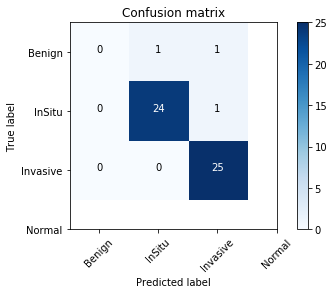

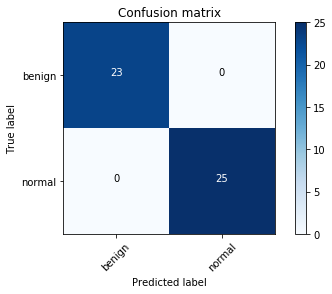

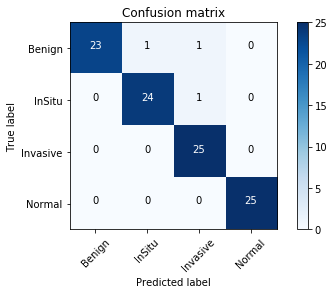

In [61]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotate(10), RandomDihedral(), RandomFlip()]
val_idxs = get_crossv_idxs(cross_idx, 4)
data = get_data('train_carci.csv', model_carci, sz, bs, val_idxs, aug=aug)
learner_carci = ConvLearner.from_model_data(model_carci, data)
learner_carci.load('bin_carci_bs10_98')
preds_carci = np.argmax(lp_carci, axis=1)
carci_idx, = np.where(preds_carci==0)
ncarci_idx, = np.where(preds_carci==1)

data = get_data('train_multi.csv', model_invis, sz, bs, val_idxs, aug=aug)
learner_invis = ConvLearner.from_model_data(model_invis, data)
learner_invis.load('ft_carci_invis_2gps_lay_98')
lp_invis, y_inv = learner_invis.predict_with_targs()
plot_cm(data.classes, y_inv[carci_idx], pred_invis[carci_idx]+1)
insitu_idx, = np.where(pred_invis[carci_idx]==0)
invasive_idx, = np.where(pred_invis[carci_idx]==1)

learner_norbe = ConvLearner.from_model_data(model_norbe, data)
learner_norbe.load('bin_norbe_bs10_100')
lp_norbe, y_norbe = learner_norbe.predict_with_targs()
pred_norbe = np.argmax(lp_norbe, axis=1)
pn = pred_norbe[ncarci_idx]
print(np.unique(pn), np.unique(y_norbe[ncarci_idx]))
plot_cm(["benign", "normal"], np.clip(y_norbe[ncarci_idx], 0, 1), pn)
benign_idx, = np.where(pred_norbe[ncarci_idx]==0)
normal_idx, = np.where(pred_norbe[ncarci_idx]==1)

preds = pred_norbe
preds[ncarci_idx[normal_idx]] = 3
preds[ncarci_idx[benign_idx]] = 0
preds[carci_idx[invasive_idx]] = 2
preds[carci_idx[insitu_idx]] = 1
plot_cm(data.classes, y_norbe, preds)
(preds==y_norbe).mean(), (preds==y_inv).mean()




In [55]:
def predict_aug(learner):
    pred = learner.TTA()
    aug_logs,y = learner.TTA()
    log_preds = np.mean(aug_logs, axis=0)
    return log_preds, y

def predict_simply(learner):
    return learner.predict_with_targs()

def inference_idx(learner, infer, mask=None):
    lp, y = infer(learner)
    preds = np.argmax(lp, axis=1)
    if mask is None:
        c1_idx, = np.where(preds==0)
        c2_idx, = np.where(preds==1)
    else:
        c1_idx, = np.where(preds[mask]==0)
        c2_idx, = np.where(preds[mask]==1)
    
    return c1_idx, c2_idx, preds, y

    
def combineResults(learners, data_multi, aug=False):
    learner_carci, learner_invis, learner_norbe = learners
    infer = predict_aug if aug else predict_simply
    
    lp_carci, y_carci = infer(learner_carci)
    preds_carci = np.argmax(lp_carci, axis=1)
    carci_idx, = np.where(preds_carci==0)
    ncarci_idx, = np.where(preds_carci==1)
    
    lp_invis, y_inv = infer(learner_invis)
    pred_invis = np.argmax(lp_invis, axis=1)
    insitu_idx, = np.where(pred_invis[carci_idx]==0)
    invasive_idx, = np.where(pred_invis[carci_idx]==1)
    
    lp_norbe, y_norbe = infer(learner_norbe)
    pred_norbe = np.argmax(lp_norbe, axis=1)
    benign_idx, = np.where(pred_norbe[ncarci_idx]==0)
    normal_idx, = np.where(pred_norbe[ncarci_idx]==1)
    
    preds = pred_norbe
    preds[ncarci_idx[normal_idx]] = 3
    preds[ncarci_idx[benign_idx]] = 0
    preds[carci_idx[invasive_idx]] = 2
    preds[carci_idx[insitu_idx]] = 1
    
    return preds, y_norbe

[[12  5  8  0]
 [ 2 13  4  6]
 [ 8 12  0  5]
 [ 0  3  3 19]]


0.44

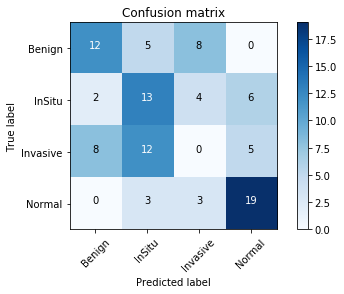

In [59]:
data = get_data('train_multi.csv', model_invis, sz, bs, val_idxs, aug=aug)
learner_invis = ConvLearner.from_model_data(model_invis, data)
learner_invis.load('ft_carci_invis_2gps_lay_98')
learner_norbe = ConvLearner.from_model_data(model_norbe, data)
learner_norbe.load('bin_norbe_bs10_100')
#ft_carci_invis_2gps_lay_98
learners = (learner_carci, learner_invis, learner_norbe)
preds, y = combineResults(learners, data)
plot_cm(data.classes, y, preds)
(preds==y).mean()

In [20]:
# lp_carci, y_carci = learner_carci.predict_with_targs()

In [60]:
if len(lp_carci.shape)>2:
    lp_carci = comb_strategy(lp_carci)

preds_carci = np.argmax(lp_carci, axis=1)
carci_idx, = np.where(preds_carci==0)
ncarci_idx, = np.where(preds_carci==1)

In [14]:
data.val_ds.fnames[carci_idx]

array(['b014.jpg', 'b015.jpg', 'b021.jpg', 'b030.jpg', 'b038.jpg', 'b051.jpg', 'b058.jpg', 'b059.jpg',
       'b062.jpg', 'b072.jpg', 'b077.jpg', 'b081.jpg', 'b085.jpg', 'is014.jpg', 'is015.jpg', 'is021.jpg',
       'is027.jpg', 'is030.jpg', 'is032.jpg', 'is041.jpg', 'is049.jpg', 'is051.jpg', 'is058.jpg', 'is059.jpg',
       'is062.jpg', 'is076.jpg', 'is085.jpg', 'is087.jpg', 'is091.jpg', 'is095.jpg', 'iv014.jpg', 'iv027.jpg',
       'iv030.jpg', 'iv038.jpg', 'iv041.jpg', 'iv051.jpg', 'iv059.jpg', 'iv068.jpg', 'iv072.jpg', 'iv087.jpg',
       'iv091.jpg', 'iv095.jpg', 'n025.jpg', 'n027.jpg', 'n030.jpg', 'n049.jpg', 'n055.jpg', 'n077.jpg'],
      dtype='<U9')

In [53]:
data_carci = get_data('train_invis.csv', model_invis, sz, bs, get_crossv_idxs(cross_idx, 2), aug=aug)
data_carci.val_ds.fnames

array(['is014.jpg', 'is015.jpg', 'is021.jpg', 'is025.jpg', 'is027.jpg', 'is030.jpg', 'is032.jpg', 'is038.jpg',
       'is041.jpg', 'is049.jpg', 'is051.jpg', 'is055.jpg', 'is058.jpg', 'is059.jpg', 'is062.jpg', 'is068.jpg',
       'is072.jpg', 'is076.jpg', 'is077.jpg', 'is081.jpg', 'is085.jpg', 'is087.jpg', 'is089.jpg', 'is091.jpg',
       'is095.jpg', 'iv014.jpg', 'iv015.jpg', 'iv021.jpg', 'iv025.jpg', 'iv027.jpg', 'iv030.jpg', 'iv032.jpg',
       'iv038.jpg', 'iv041.jpg', 'iv049.jpg', 'iv051.jpg', 'iv055.jpg', 'iv058.jpg', 'iv059.jpg', 'iv062.jpg',
       'iv068.jpg', 'iv072.jpg', 'iv076.jpg', 'iv077.jpg', 'iv081.jpg', 'iv085.jpg', 'iv087.jpg', 'iv089.jpg',
       'iv091.jpg', 'iv095.jpg'],
      dtype='<U9')

In [34]:
data = get_data('train_multi.csv', model_invis, sz, bs, val_idxs, aug=aug)
learner_invis = ConvLearner.from_model_data(model_invis, data)
# learner.load('bin_carci_bs10_98')
learner_invis.load('ft_carci_invis_2gps_lay_98')
# learner_invis.data.classes = ['InSitu', 'Invasive']
lp_invis, y_inv = learner_invis.predict_with_targs()
# accuracy(lp_invis,y_inv)
pred_invis = np.argmax(lp_invis, axis=1)

In [49]:
ncarci_idx

array([ 8, 34, 46, 53, 55, 56, 59, 61, 66, 67, 68, 69, 70, 71, 73])

In [50]:
np.unique(y_inv)
# plot_cm(data.classes, y_inv, pred_invis+1)
plot_cm(data.classes, y_inv[carci_idx], pred_invis[carci_idx]+1)
insitu_idx, = np.where(pred_invis[carci_idx]==0)
invasive_idx, = np.where(pred_invis[carci_idx]==1)

In [51]:
learner_norbe = ConvLearner.from_model_data(model_norbe, data)
# learner.load('bin_carci_bs10_98')
learner_norbe.load('bin_norbe_bs10_100')
# learner_invis.data.classes = ['InSitu', 'Invasive']
lp_norbe, y_norbe = learner_norbe.predict_with_targs()
pred_norbe = np.argmax(lp_norbe, axis=1)

In [56]:
pn = pred_norbe[ncarci_idx]
# pn[pn==1] = 3
print(np.unique(pn), np.unique(y_norbe[ncarci_idx]))
plot_cm(["benign", "normal"], np.clip(y_norbe[ncarci_idx], 0, 1), pn)
benign_idx, = np.where(pred_norbe[ncarci_idx]==0)
normal_idx, = np.where(pred_norbe[ncarci_idx]==1)

[[ 1 16  8  0]
 [ 0 22  1  2]
 [ 7  0 13  5]
 [ 0 23  2  0]]


(0.35999999999999999, 0.35999999999999999)

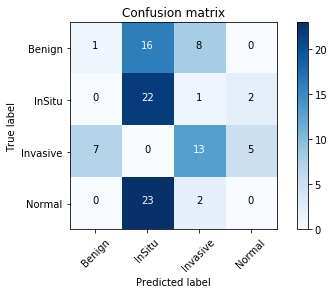

In [57]:
preds = pred_norbe
preds[ncarci_idx[normal_idx]] = 3
preds[ncarci_idx[benign_idx]] = 0
preds[carci_idx[invasive_idx]] = 2
preds[carci_idx[insitu_idx]] = 1
plot_cm(data.classes, y_norbe, preds)
(preds==y_norbe).mean(), (preds==y_inv).mean()

[[25  0  0  0]
 [ 0 23  1  1]
 [ 0  0 24  1]
 [ 0  0  0 25]]


(0.96999999999999997, 0.0)

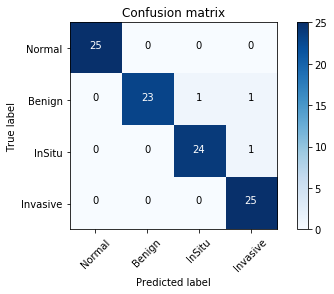

In [31]:
preds = pred_norbe
preds[ncarci_idx[normal_idx]] = 0
preds[ncarci_idx[benign_idx]] = 1
preds[carci_idx[invasive_idx]] = 3
preds[carci_idx[insitu_idx]] = 2
nor, be = y_norbe==3, y_norbe==0
iv, ins = y_norbe==2, y_norbe==1
y_norbe[nor] = 0
y_norbe[be] = 1
y_norbe[ins] = 2
y_norbe[iv] = 3

plot_cm(["Normal", "Benign", "InSitu","Invasive"], y_norbe, preds)
(preds==y_norbe).mean(), (preds==y_inv).mean()

# Combine the 3 models

In [200]:
gpu_type = torch.cuda.FloatTensor
def build_model(weight_path, device=gpu_type):
    top_layers_bin = [AdaptiveConcatPool2d(), Flatten(), 
            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.25), nn.Linear(4096,512), nn.ReLU(), 
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.5), 
            nn.Linear(512,2), 
            nn.LogSoftmax()]
    model = nn.Sequential(*list(resnet50().children())[:-2])
    for k, l in enumerate(top_layers_bin):
        model.add_module(str(7+k+1), l)
    load_model(model, weight_path)
    model.type(device)
    model.eval()
    return model

# model_carci = nn.Sequential(*list(resnet50().children())[:-2])
# # model_norbe = nn.Sequential(*list(resnet50().children())[:-2])
# # model_invis = nn.Sequential(*list(resnet50().children())[:-2])
# for k, l in enumerate(top_layers_bin):
#     model_carci.add_module(str(7+k+1), l)
# #     model_norbe.add_module(str(7+k+1), l)
# #     model_invis.add_module(str(7+k+1), l)
    


In [201]:

model_carci = build_model(f'{PATH}models/bin_carci_bs10_98.h5')
model_norbe = build_model(f'{PATH}models/bin_norbe_bs10_100.h5')
model_invis = build_model(f'{PATH}models/ft_carci_invis_2gps_lay_98.h5')
# load_model(model_carci, f'{PATH}models/bin_carci_bs10_98.h5')
# load_model(model_norbe, f'{PATH}models/bin_norbe_bs10_100.h5')
# load_model(model_invis, f'{PATH}models/ft_carci_invis_2gps_lay_98.h5')
# model_carci.type(gpu_type)
# model_carci.eval()
# model_invis.type(gpu_type)
# model_norbe.type(gpu_type)
# model_invis.eval()
# model_norbe.eval()
print()


In [261]:
arch=resnet50
sz=299
fn = f'{PATH}Photos/Invasive/iv089.tif'
trn_tfms, val_tfms = tfms_from_model(model_carci, sz, aug_tfms=transforms_top_down, max_zoom=1.05) # get transformations
im = open_image(fn)
im_val = val_tfms(im)
x = torch.from_numpy(im_val).type(gpu_type)
# x = x.permute(0,3,1,2)
x = Variable(x).unsqueeze(0)
print(x.size())

torch.Size([1, 3, 299, 299])


In [265]:
log_pred = model_carci(x)
print(log_pred, log_pred.data.cpu().numpy())
pred = np.argmax(log_pred.data.cpu().numpy())
# pred = 0 if pred==1 else 1
idx_class = None
if pred == 0:
    print('carci image')
    log_pred = model_invis(x)
    pred = np.argmax(log_pred.data.cpu().numpy())
    idx_class  = 2 if pred==0 else 3
    print(idx_class)
else:
    print('non carci image')
    log_pred = model_norbe(x)
    pred = np.argmax(log_pred.data.cpu().numpy())
    idx_class  = 1 if pred==0 else 0
    print(idx_class)
submit_classes = ['Normal', 'Benign', 'InSitu', 'Invasive']
'class prediction: '+str(idx_class)+' => '+ submit_classes[idx_class]

Variable containing:
-0.0271 -3.6211
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]
 [[-0.02712 -3.62112]]
carci image
3


'class prediction: 3 => Invasive'

# Only 1 model

In [176]:
load_model(model, f'{PATH}models/multi_exp2_ps.6_95.h5')
model.type(gpu_type)
model.eval()
print()

In [181]:
arch=resnet50
sz=299
fn = f'{PATH}Photos/InSitu/is099.tif'
trn_tfms, val_tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05) # get transformations
im = open_image(fn)
im_val = val_tfms(im)

In [182]:

x = torch.from_numpy(im_val).type(torch.cuda.FloatTensor)
# x = x.permute(0,3,1,2)
print(x.size())

torch.Size([3, 299, 299])


In [183]:
log_pred = model(Variable(x).unsqueeze(0))
log_pred

Variable containing:
-8.5315e+00 -2.9755e-04 -9.4363e+00 -1.0785e+01
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]

In [184]:
pred = np.argmax(log_pred.data.cpu().numpy())
devt_classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
submit_classes = {'Normal':0, 'Benign':1, 'InSitu':2, 'Invasive':3}
f'class prediction: {submit_classes[devt_classes[pred]]} => {devt_classes[pred]}'

'class prediction: 2 => InSitu'